# **House Price Regression**

## 1. Data Loading

In [36]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [37]:
# Fetch Ames housing dataset
housing = fetch_openml(name='house_prices', as_frame=True, parser='auto')

In [38]:
# Put data into dataframe and combine it with the target column
df = housing.data.copy()
df['SalePrice'] = housing.target

print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(df.head())

Rows: 1460
Columns: 81
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice 

## 2. Data Cleaning

There are 81 columns. That is too much columns, so we need to find out which ones are significant enough to matter.

In [39]:
# Use correlation matrix to see which ones are significant enough
# 1. Calculate correlations for numeric columns (only can be done on numbers)
corr_matrix = df.select_dtypes(include=['number']).corr()

# 2. Sort features based on best correlation with SalePrice (target)
print(corr_matrix['SalePrice'].sort_values(ascending=False).head(10))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


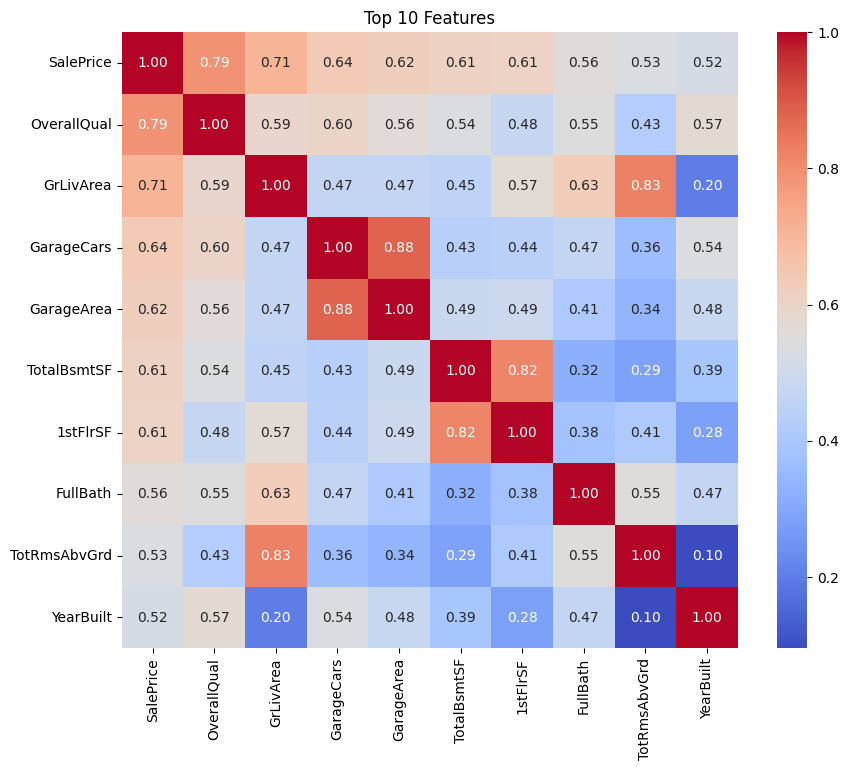

In [40]:
# 3. Grab the top 10 features
k = 10
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index

# 4. Visualize the matrix
plt.figure(figsize=(10,8))
sns.heatmap(df[cols].corr(), annot=True, square=True, fmt='.2f', cmap='coolwarm')
plt.title("Top 10 Features")
plt.show()

## 3. Data Cleaning

Notes:
- OverallQual (Overall Quality) is the most important feature to the SalePrice.
- GarageCars and GarageArea are heavily correlated with each other, indicating multicollinearity.

In [41]:
# Select the top features based on the correlation matrix
# We'll use 7 columns + target (lucky 7)
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF'] # Only use GarageCars, since GarageArea pretty much describes the same thing
target = 'SalePrice'

# Copy the dataframe
data = df[features + [target]].copy()

# Check for missing values
print(data.isnull().sum()) # No missing values, so no cleaning required

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
1stFlrSF       0
SalePrice      0
dtype: int64


## 4. Training

**Model used:** Linear Regression

In [42]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [43]:
# 1. Split data
X = data[features]
y = data[target]

# 2. Train test split: 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# 3. Training
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [45]:
# 4. Make the predictions
predictions = model.predict(X_test)

In [46]:
# 5. Evaluation
# Use R2 score (0-1, where 1 is best)
r2 = r2_score(y_test, predictions)

# Use MSE (Mean Squared Error)
mse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R2 Score: {r2}')
print(f'MSE: {mse}')

R2 Score: 0.7955277762397539
MSE: 39602.6344647682


**Result:**
*   R2 (0.8): The model excellently explains 80% of the variance through the features chosen. The remaining 20% are explained through the features not included.
*   MSE (39602): On average, the model has a margin of error of about $39,602. This is a decent estimate for higher priced houses, but not so much for cheaper houses.

## 5. Visualization

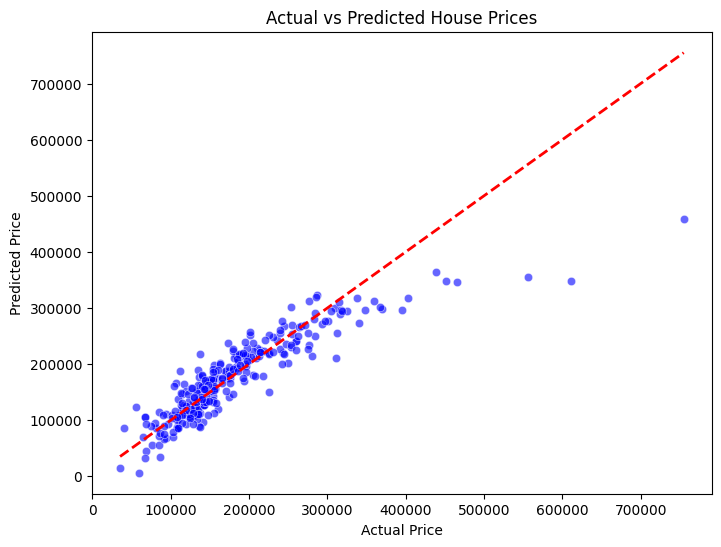

In [47]:
plt.figure(figsize=(8,6))

# 1. Scatter plot
# Between actual results and predicted results
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color='blue')

# 2. Line graph
# Show the actual price lines
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.show()

The lower-priced houses follows the regression properly, however the higher-priced houses do not. This is most likely caused by leaving out features that might be important to expensive houses, such as swimming pools.